## POS tagging using modified Viterbi

### Data Preparation

In [57]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter

In [58]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\X1\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [59]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [60]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('Critics', 'NOUN'), ('like', 'ADP'), ('Mr.', 'NOUN'), ('Murray', 'NOUN'), ('``', '.'), ('are', 'VERB'), ('looking', 'VERB'), ('for', 'ADP'), ('witches', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('people', 'NOUN'), ('who', 'PRON'), ('*T*-68', 'X'), ('use', 'VERB'), ('computers', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('trade', 'VERB'), ('are', 'VERB'), ('a', 'DET'), ('convenient', 'ADJ'), ('boogieman', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('0', 'X'), ('*T*-3', 'X'), ('J.', 'NOUN'), ('Thomas', 'NOUN'), ('Allen', 'NOUN'), (',', '.'), ('president', 'NOUN'), ('of', 'ADP'), ('Advanced', 'NOUN'), ('Investment', 'NOUN'), ('Management', 'NOUN'), ('Inc.', 'NOUN'), (',', '.'), ('a', 'DET'), ('Pittsburgh', 'NOUN'), ('firm', 'NOUN'), ('that', 'DET'), ('*T*-1', 'X'), ('runs', 'VERB'), ('a', 'DET'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('fund', 'NOUN'), ('that', 'DET'), ('*T*-2', 'X'), ('uses', 'VERB'), ('index', 'NOUN'), ('arbitrage', 'NOUN'), ('.', '.'

In [61]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70739

In [62]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Critics',
 'like',
 'Mr.',
 'Murray',
 '``',
 'are',
 'looking',
 'for',
 'witches',
 ',']

In [63]:
# vocabulary
V = set(tokens)
print(len(V))

10348


In [64]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

### Build the vanilla Viterbi based POS tagger

#### Calculating Emission Probabilities 

In [65]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [66]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Calculating Transition Probabilities

In [67]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#### Creating t x t transition matrix of tags

In [68]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [69]:
tags_matrix

array([[2.62972206e-01, 1.45916015e-01, 2.78798565e-02, 2.42442057e-01,
        8.96663219e-03, 1.75412800e-02, 1.14165321e-02, 4.99779498e-03,
        4.25792560e-02, 1.78058699e-01, 4.41961884e-02, 1.30334655e-02],
       [1.11769058e-01, 1.69186845e-01, 2.14761555e-01, 3.48947868e-02,
        2.36861575e-02, 8.01522657e-02, 6.43967465e-02, 3.67981382e-02,
        5.71005605e-03, 9.28412825e-02, 2.98191812e-02, 1.35983929e-01],
       [6.55701756e-02, 2.08552629e-01, 7.06140324e-02, 1.62280709e-01,
        1.97368418e-03, 2.56578941e-02, 1.95175447e-02, 5.54824546e-02,
        1.07456138e-02, 1.41885966e-01, 1.81140348e-01, 5.65789491e-02],
       [2.28059560e-01, 8.93354341e-02, 2.62680054e-02, 9.16353986e-02,
        8.26776400e-02, 5.19307591e-02, 4.56361212e-02, 6.51252866e-02,
        5.78622445e-02, 9.16353986e-02, 2.42101448e-03, 1.67292088e-01],
       [3.48799348e-01, 1.54660158e-02, 2.19780222e-01, 1.18437119e-01,
        1.78266183e-01, 2.44200253e-03, 3.45950350e-02, 1.62

In [70]:
# For better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [71]:
tags_df

,NOUN,VERB,X,.,NUM,ADV,ADJ,PRON,CONJ,ADP,PRT,DET
NOUN,0.262972,0.145916,0.027880,0.242442,0.008967,0.017541,0.011417,0.004998,0.042579,0.178059,0.044196,0.013033
VERB,0.111769,0.169187,0.214762,0.034895,0.023686,0.080152,0.064397,0.036798,0.005710,0.092841,0.029819,0.135984
X,0.065570,0.208553,0.070614,0.162281,0.001974,0.025658,0.019518,0.055482,0.010746,0.141886,0.181140,0.056579
.,0.228060,0.089335,0.026268,0.091635,0.082678,0.051931,0.045636,0.065125,0.057862,0.091635,0.002421,0.167292
NUM,0.348799,0.015466,0.219780,0.118437,0.178266,0.002442,0.034595,0.001628,0.014245,0.033374,0.029304,0.003663
ADV,0.029783,0.337094,0.023014,0.139892,0.032942,0.079422,0.126805,0.013538,0.006769,0.127708,0.014440,0.068592
ADJ,0.705843,0.011246,0.021830,0.063065,0.020066,0.004190,0.066152,0.000662,0.017200,0.074311,0.010805,0.004631
PRON,0.211458,0.477604,0.093750,0.040104,0.007292,0.034375,0.072917,0.007812,0.005208,0.026042,0.012500,0.010937
CONJ,0.345194,0.167915,0.007491,0.036829,0.038077,0.052434,0.117978,0.056180,0.000624,0.050562,0.006242,0.120474
ADP,0.324049,0.008758,0.033597,0.038622,0.060732,0.013352,0.109691,0.068342,0.000718,0.015793,0.001436,0.324910


In [72]:
tags_df.loc['.', :]

NOUN    0.228060
VERB    0.089335
X       0.026268
.       0.091635
NUM     0.082678
ADV     0.051931
ADJ     0.045636
PRON    0.065125
CONJ    0.057862
ADP     0.091635
PRT     0.002421
DET     0.167292
Name: ., dtype: float32

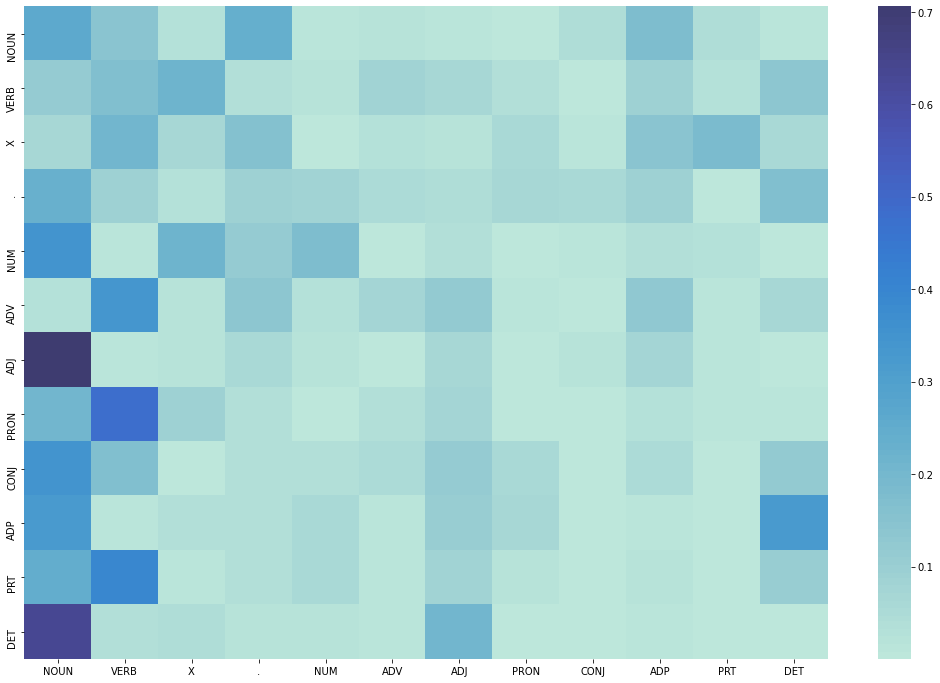

In [73]:
# plotting a heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, center=1)
plt.show()

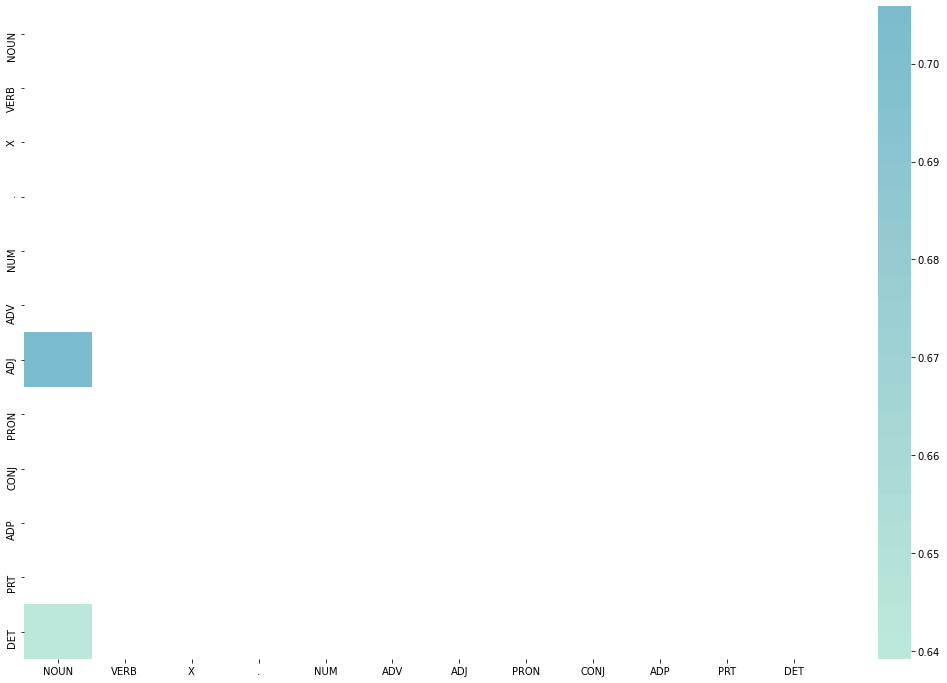

In [74]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, center=1)
plt.show()

#### Implementing Viterbi Algorithm

In [75]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [76]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Neil', 'NOUN'),
  ('Kuvin', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('general', 'ADJ'),
  ('manager', 'NOUN'),
  ('of', 'ADP'),
  ('WHAS', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('CBS', 'NOUN'),
  ('affiliate', 'NOUN'),
  ('in', 'ADP'),
  ('Louisville', 'NOUN'),
  (',', '.'),
  ('says', 'VERB'),
  ('0', 'X'),
  ('``', '.'),
  ('Cosby', 'NOUN'),
  ("''", '.'),
  ('gets', 'VERB'),
  ('the', 'DET'),
  ('station', 'NOUN'),
  ("'s", 'PRT'),
  ('highest', 'ADJ'),
  ('ratings', 'NOUN'),
  ('and', 'CONJ'),
  ('0', 'X'),
  ('he', 'PRON'),
  ("'s", 'VERB'),
  ('``', '.'),
  ('pleased', 'VERB'),
  ('*-1', 'X'),
  ('.', '.'),
  ("''", '.')],
 [('Attorneys', 'NOUN'),
  ('have', 'VERB'),
  ('argued', 'VERB'),
  ('since', 'ADP'),
  ('1985', 'NUM'),
  (',', '.'),
  ('when', 'ADV'),
  ('the', 'DET'),
  ('law', 'NOUN'),
  ('took', 'VERB'),
  ('effect', 'NOUN'),
  ('*T*-1', 'X'),
  (',', '.'),
  ('that', 'ADP'),
  ('they', 'PRON'),
  ('can', 'VERB'),
  ('not', 'ADV'),
  ('provide', 'VERB'),
  

In [116]:
# tagging the test sentences
tagged_seq = Viterbi(test_tagged_words)

In [118]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

### Solve the problem of unknown words

In [79]:
# Read the txt file

sample_text = []
f = open("Test_sentences.txt", "r", encoding='utf-8')
for txt in f:
    sample_text.append(txt)
sample_text

['Android is a mobile operating system developed by Google.\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n',
 'Show me the cheapest round trips from Dallas to Atlanta\n',
 'I would like to see flights from Denver to Philadelphia.\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n',
 'NASA invited social medi

In [80]:
# cleaning up the text file array
final_text = []
for txt in sample_text:
    if txt.strip() != '':
        final_text.append(txt.strip())
final_text

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [81]:
# Tokenize the lines

#nltk.download('punkt')
tokenized_words=[]

for words in final_text:
    for tokens in word_tokenize(words):
        tokenized_words.append(tokens)
tokenized_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [82]:
# Since we have a lot of tokens, we need to find the uniqe ones which aren't in training corpus

unique_tokens = list(set(tokenized_words) - set(tokens))
unique_tokens

['every',
 'round',
 'news',
 '2013',
 'gave',
 ',',
 'trips',
 'invited',
 'has',
 '2015',
 'The',
 'service',
 'entering',
 'would',
 'firehose',
 'post',
 'four',
 'access',
 'Atlanta',
 'about',
 '3',
 'personality',
 'a',
 'mobile',
 'ICESAT-2',
 'in',
 'made',
 'from',
 'like',
 'to',
 'first',
 'years',
 'Cup',
 '11th',
 'experience',
 'best-selling',
 'Philadelphia',
 '2011',
 'an',
 'Eastern',
 'San',
 'OS',
 'and',
 "'s",
 'with',
 'football',
 'time',
 'smartphones',
 'as',
 'businessman',
 'contested',
 'it',
 'Google',
 '2018',
 'me',
 'networking',
 'be',
 'leaving',
 'interact',
 'on',
 'is',
 'developed',
 'Twitter',
 'system',
 'tablets',
 'online',
 'cheapest',
 'international',
 'Satellite',
 'been',
 'that',
 'see',
 'held',
 'of',
 'Show',
 'tournament',
 'Before',
 'worldwide',
 'social',
 'Donald',
 'users',
 '21st',
 'launch',
 'price',
 'arriving',
 'since',
 'television',
 'Trump',
 'deal',
 'messages',
 'domineering',
 'Denver',
 'once',
 'Francisco',
 'tweet

In [83]:
# Let's check the list of incorrectly tagged words

misclassified = []

for w1, w2 in enumerate(zip(tagged_seq, test_run_base)):
    if w2[0] != w2[1]:
        misclassified.append([test_run_base[w1-1],w2])


# Checking its count

misclassified_count = Counter(pair[1][0][1] for pair in misclassified)
misclassified_count

Counter({'DET': 2, 'NOUN': 6, 'VERB': 1})

#### Checking POS followed by one another

In [94]:
# Adjectives followed by Nouns
tags = [pair[1] for pair in train_tagged_words]
adj_tags = [t for t in tags if t == 'ADJ']
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) if t=='ADJ' and tags[index+1]=='NOUN']
print("ADJ -> N:  " + str(len(adj_noun_tags) / len(adj_tags)))


# DET followed by Nouns
tags = [pair[1] for pair in train_tagged_words]
det_tags = [t for t in tags if t == 'DET']
det_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) if t=='DET' and tags[index+1]=='NOUN']
print("DET -> N:  " + str(len(det_noun_tags) / len(det_tags)))


# Verbs followed by Nouns
tags = [pair[1] for pair in train_tagged_words]
v_tags = [t for t in tags if t == 'VERB']
v_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) if t=='VERB' and tags[index+1]=='NOUN']
print("V -> N:  " + str(len(v_noun_tags) / len(v_tags)))

# Adverbs followed by Verbs
tags = [pair[1] for pair in train_tagged_words]
adv_tags = [t for t in tags if t == 'ADV']
adv_v_tags = [(t, tags[index+1]) for index, t in enumerate(tags) if t=='ADV' and tags[index+1]=='VERB']
print("ADV -> V:  " + str(len(adv_v_tags) / len(adv_tags)))


ADJ -> N:  0.7058434399117971
DET -> N:  0.6391836734693878
V -> N:  0.11176905995558846
ADV -> V:  0.3370938628158845


#### Lexicon Tagging (Combined with unigram and regex)

In [120]:
# specify patterns for tagging

patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns from adjectives
    (r'.*', 'NOUN'),                    # nouns
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN')                # plural nouns
]

rule_based_tagger = nltk.RegexpTagger(patterns)
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
unigram_regex_accuracy = lexicon_tagger.evaluate(test_set)

#### Using Bigram Tagger

In [121]:
bigram_tagger = nltk.BigramTagger(train_set, backoff = lexicon_tagger)
bigram_accuracy = bigram_tagger.evaluate(test_set)

#### Using Trigram Tagger

In [122]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_accuracy = trigram_tagger.evaluate(test_set)

In [123]:
# Let's check a trigram tagger backed up by a regex

trigram_tagger = nltk.TrigramTagger(train_set, backoff = rule_based_tagger)
trigram_regex_accuracy = trigram_tagger.evaluate(test_set)

In [113]:
# The Viterbi algorithm is failing to tag an unkonwn word and hence we should use a rule based technique.
# Let's create a rule based N-gram tagger and modify the viterbi algorithm
# Whenever the state probability becomes zero, the rule based tagger should provide a tag to it

def custom_tagger(token, train_set = train_set):
    
    patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns from adjectives
    (r'.*', 'NOUN'),                    # nouns
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN')                # plural nouns
    ]
    regex_tagger = nltk.RegexpTagger(patterns)
    uni_tagger = nltk.UnigramTagger(train_set, backoff=regex_tagger)
    bi_tagger = nltk.BigramTagger(train_set, backoff=uni_tagger)
    custom_tagger = nltk.TrigramTagger(train_set, backoff=bi_tagger)
    return custom_tagger.tag_sents([[(token)]])

In [114]:
def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = custom_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)

            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [119]:
modified_tagged_seq = Viterbi_modified(test_tagged_words)
check = [i for i, j in zip(modified_tagged_seq, test_run_base) if i == j] 
modified_viterbi_accuracy = len(check)/len(modified_tagged_seq)

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [130]:
# create a dataset of obtained accuracies

accuracies = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], ['Unigram Tagger + Regex',unigram_regex_accuracy*100], ['Bigram Tagger', bigram_accuracy*100],
             ['Trigram Tagger', trigram_accuracy*100], ['Trigram tagger + Regex', trigram_regex_accuracy*100], ['Modified Viterbi', modified_viterbi_accuracy*100]]

accuracy_df = pd.DataFrame(accuracies, columns = ["Algorithm", "Accuracy"])
accuracy_df.set_index('Algorithm', drop = True, inplace = True)
accuracy_df

,Accuracy
Algorithm,
Vanilla Viterbi,94.409938
Unigram Tagger + Regex,94.501787
Bigram Tagger,94.789057
Trigram Tagger,94.765675
Trigram tagger + Regex,85.573037
Modified Viterbi,93.788820


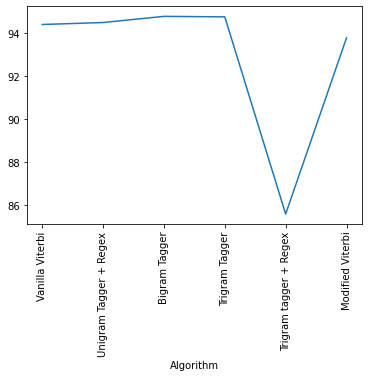

In [144]:
accuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [153]:
# The Cases where the tokens are incorrectly tagged are mentioned below

vit = []
vit_modified = []
for txt in final_text:
    vit.append(Viterbi(word_tokenize(txt)))
    vit_modified.append((Viterbi_modified(word_tokenize(txt))))

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NOUN'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NOUN'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NOUN'),
  ('that', 'ADP'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'NOUN'),
  ('news', 'NOUN'),
  ('and', 'C

In [156]:
vit_modified

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'VERB'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'ADP'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'NOUN'),
  ('news', 'NOUN'),
  ('and', 'CONJ

In [157]:
vit

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NOUN'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NOUN'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NOUN'),
  ('that', 'ADP'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'NOUN'),
  ('news', 'NOUN'),
  ('and', 'C